<center>
  <h2>Trabajo Laboratorio de Implementación III - MCD Virtual Cohorte 2022</h2>
  <h3>Forecasting para una Empresa de Consumo Masivo</h3>
  <h4>Primeros pasos DARTS: modelo para producto estrella</h4>
</center>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
# !pip install darts
from darts import TimeSeries
# !pip install u8darts
from darts.metrics import mape
from darts.models import TBATS, AutoARIMA, Theta
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from darts.models import LinearRegressionModel
import ipywidgets as widgets
widgets.IntSlider()

IntSlider(value=0)

- Modelo base producto estrella (20001)

In [17]:
df = pd.read_csv("C:/Users/usuario/otros/Desktop/MCD/6 Labo III/Forecasting Problem/Datasets/df_ventas_product.csv", header = None)
df.columns = ["periodo", "product_id", "tn"]
df = df.sort_values(by="periodo").reset_index(drop = True)
df.head(5)

,periodo,product_id,tn
0,2018-01-01,20001,1169.07532
1,2018-01-01,20612,4.19274
2,2018-01-01,20609,6.68825
3,2018-01-01,20606,8.14456
4,2018-01-01,20605,5.94126


In [18]:
df = df[df.product_id == 20001]
df.head(1)

,periodo,product_id,tn
0,2018-01-01,20001,1169.07532


In [19]:
# Creamos objeto TimeSeries
series = TimeSeries.from_dataframe(df,
                                   time_col="periodo",
                                   value_cols="tn",
                                   freq='MS')  # MS para indicar frecuencia mensual

# Creamos objeto TimeSeries --> Para total productos
# series = TimeSeries.from_group_dataframe(df,
#                                          group_cols="product_id",
#                                          time_col="periodo",
#                                          value_cols="tn",
#                                          freq='MS')  # MS para indicar frecuencia mensual

<Axes: xlabel='periodo'>

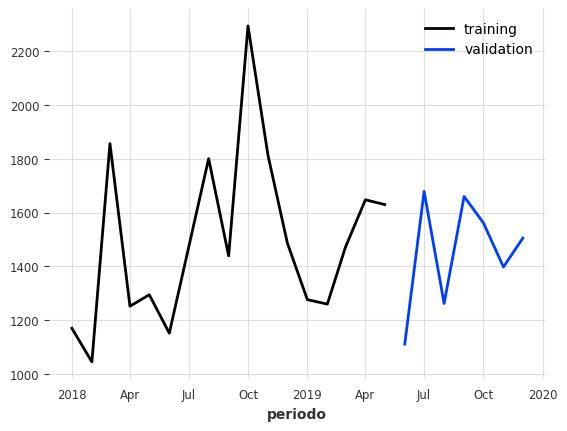

In [20]:
# Dividimos serie en entrenamiento y validación
train, val = series.split_before(pd.Timestamp("20190601"))
train.plot(label="training")
val.plot(label="validation")

In [21]:
# Planteamos un modelo y evaluamos
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    error = ((sum(abs(val - forecast)) / sum(val)).values()[0][0])*100
    return print(f"La tasa de error (empresa) en el conjunto de validación para modelo {model} es {error} y el MAPE es {mape(val, forecast)}")
    
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

La tasa de error (empresa) en el conjunto de validación para modelo TBATS() es 20.49030062250991 y el MAPE es 20.428853900873502
La tasa de error (empresa) en el conjunto de validación para modelo AutoARIMA() es 11.255847624824273 y el MAPE es 12.291202456159327
La tasa de error (empresa) en el conjunto de validación para modelo Theta() es 15.585515161077554 y el MAPE es 16.04049030246743


In [22]:
# Seleccionamos el mejor modelo
best_model = AutoARIMA()
best_model.fit(train)
forecast = best_model.predict(len(val))

  0%|          | 0/9 [00:00<?, ?it/s]

MAPE = 11.08%


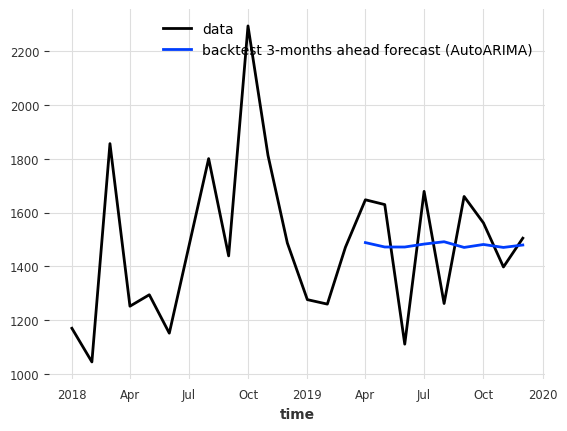

In [23]:
# Backtesting: simular pronósticos históricos
# Tenemos un modelo probado en nuestro conjunto de validación, pero
# ¿Cómo podemos saber el rendimiento que habríamos obtenido si hubiésemos estado utilizando este modelo históricamente?
# El backtesting simula predicciones que se habrían obtenido históricamente con un modelo determinado.
# Dichos pronósticos simulados siempre se definen con respecto a un horizonte de pronóstico
# Vemos el error sobre esos forecast históricos. Si aqui da mucho peor que en validación hay sobreajuste
historical_fcast_autoa_arima = best_model.historical_forecasts(series, start=0.6, forecast_horizon=3, verbose=True)
series.plot(label="data")
historical_fcast_autoa_arima.plot(label="backtest 3-months ahead forecast (AutoARIMA)")
# Veo mape porque tasa error empresa da error
print("MAPE = {:.2f}%".format(mape(historical_fcast_autoa_arima, series)))

Además de la serie objetivo (la serie que nos interesa pronosticar), muchos modelos en Darts también aceptan series de covariables como entrada. Las covariables son series que no queremos pronosticar, pero que pueden proporcionar información adicional útil a los modelos. Tanto los objetivos como las covariables pueden ser multivariados o univariados. Si tiene varias series de covariables debe apilarlas(stack) o concatenarlas(concatenate) para obtener una serie multivariada.

Hay dos tipos de series temporales de covariables en Darts:

- past_covariables son series que no necesariamente se conocen antes del momento del pronóstico. Estos pueden, por ejemplo, representar cosas que deben medirse y que no se conocen de antemano. Los modelos no utilizan los valores futuros de past_covariates al realizar pronósticos.
- covariables_futuras son series que se conocen de antemano, hasta el horizonte de previsión.

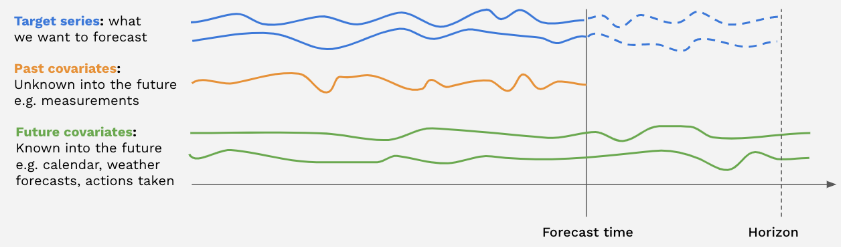

Importante: no todos los modelos admiten todos los tipos de covariables.

- Agregamos serie relacionada de juguete

In [24]:
# Ejemplo de serie covariables
series_covs = concatenate(
    [
        dt_attr(series.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series.time_index, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)

# Dividir covariables en entrenamiento y validación
# train_covs, val_covs = series_covs.split_after(pd.Timestamp("20190601"))
# train_covs, val_covs = series_covs.split_before(pd.Timestamp("20190601"))

# Crear y entrenar el modelo especificando lags y lags_past_covariates
model = LinearRegressionModel(lags=[-1, -2, -3], lags_past_covariates=[-1, -2, -3])
model.fit(train, past_covariates=series_covs)

# Realizar la predicción
pred = model.predict(len(val), past_covariates=series_covs)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


<Axes: xlabel='periodo'>

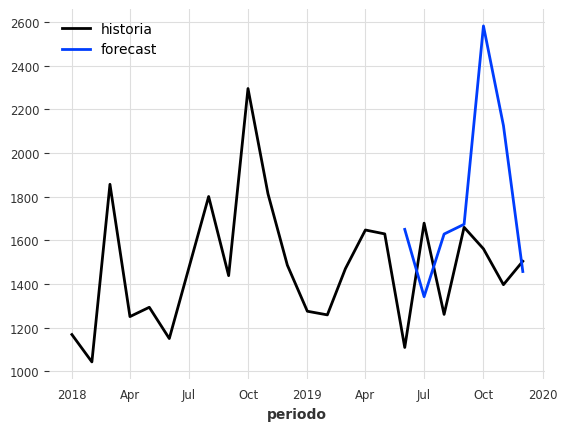

In [25]:
series.plot(label="historia")
pred.plot(label="forecast")

In [26]:
# Ejemplo de serie covariables
series_covs = concatenate(
    [
        dt_attr(series.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series.time_index, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)

# Crear y entrenar el modelo especificando lags y lags_past_covariates
model = LinearRegressionModel(lags=[-2, -3], lags_past_covariates=[-2, -3])
model.fit(series, past_covariates=series_covs)

# Realizar la predicción
pred = model.predict(n = 2, past_covariates=series_covs)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


<Axes: xlabel='periodo'>

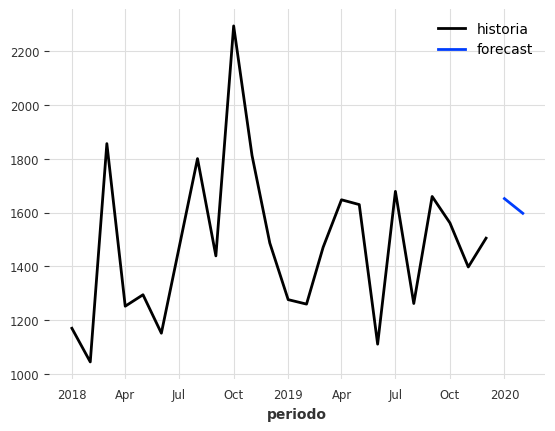

In [27]:
series.plot(label="historia")
pred.plot(label="forecast")

- Adicionar serie relacionada construida

In [28]:
related_columns = ["periodo", "product_id", "month", "quarter", "days_in_month", "sundays", "saturdays", "tn_m3", "tn_m6", "tn_m12"]
value_related_columns = related_columns[2:]

In [29]:
df_related = pd.read_csv("C:/Users/usuario/otros/Desktop/MCD/6 Labo III/Forecasting Problem/Datasets/df_related_product.csv", header = None)
df_related.columns = related_columns
df_related = df_related.sort_values(by="periodo").reset_index(drop = True)
df_related.head(5)

,periodo,product_id,month,quarter,days_in_month,sundays,saturdays,tn_m3,tn_m6,tn_m12
0,2018-01-01,20001,1,1,31,4,4,1439.75563,1030.67391,934.77222
1,2018-01-01,20337,1,1,31,4,4,13.51889,NaN,NaN
2,2018-01-01,20406,1,1,31,4,4,16.14694,7.07533,16.29007
3,2018-01-01,20636,1,1,31,4,4,1.18635,9.50914,1.85600
4,2018-01-01,20807,1,1,31,4,4,2.64613,0.72336,2.93603


In [30]:
df_related = df_related[df_related.product_id == 20001]
df_related.head(1)

,periodo,product_id,month,quarter,days_in_month,sundays,saturdays,tn_m3,tn_m6,tn_m12
0,2018-01-01,20001,1,1,31,4,4,1439.75563,1030.67391,934.77222


In [54]:
# Creamos objeto TimeSeries
related_series = TimeSeries.from_dataframe(df_related,
                                           time_col="periodo",
                                           value_cols=value_related_columns,
                                           freq='MS')  # MS para indicar frecuencia mensual

In [59]:
# Crear y entrenar el modelo especificando lags y lags_past_covariates
model = LinearRegressionModel(lags=[-2, -3], lags_future_covariates=[-2, -3])
model.fit(series, future_covariates=related_series)

# Realizar la predicción
pred = model.predict(n = 2, future_covariates=related_series)

<Axes: xlabel='periodo'>

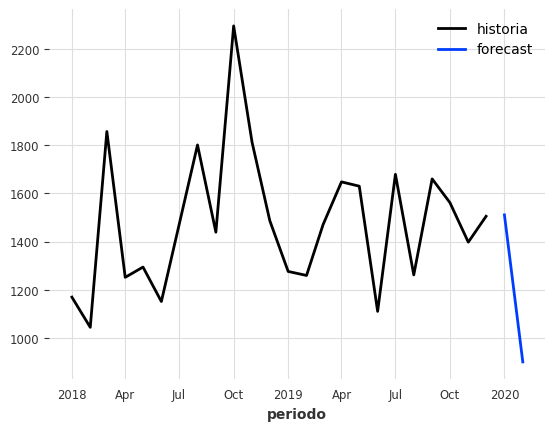

In [60]:
series.plot(label="historia")
pred.plot(label="forecast")